In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 7.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=636b8de358710cfba1d3b33d2fa0bde4ce1647a0247afd98b9ff24558bbb8f26
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.master("local[4]")\
.appName("socialnetwork")\
.getOrCreate()

In [4]:
sc = spark.sparkContext

In [5]:
df = spark.read.options(header=True,inferSchema=True).csv("Social_Network_Ads.csv")

# Exploratory Analysis

In [6]:
df.summary().show()

+-------+-----------------+------+------------------+----------------+------------------+
|summary|          User ID|Gender|               Age| EstimatedSalary|         Purchased|
+-------+-----------------+------+------------------+----------------+------------------+
|  count|              400|   400|               400|             400|               400|
|   mean|  1.56915397575E7|  null|            37.655|         69742.5|            0.3575|
| stddev|71658.32158119006|  null|10.482876597307927|34096.9602824248|0.4798639635968691|
|    min|         15566689|Female|              18.0|         15000.0|                 0|
|    25%|         15625395|  null|              29.0|         43000.0|                 0|
|    50%|         15694288|  null|              37.0|         70000.0|                 0|
|    75%|         15750335|  null|              46.0|         88000.0|                 1|
|    max|         15815236|  Male|              60.0|        150000.0|                 1|
+-------+-

In [8]:
df.count()

400

In [7]:
# Check count
df.groupby('Purchased').count().show()

+---------+-----+
|Purchased|count|
+---------+-----+
|        1|  143|
|        0|  257|
+---------+-----+



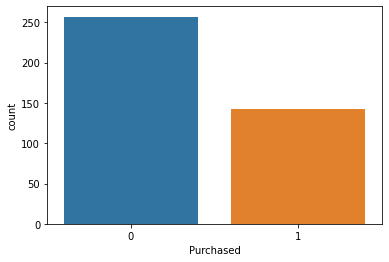

In [9]:
# Check balance
import seaborn as sns
pdf = df.toPandas()
sns.countplot(x=pdf["Purchased"])

In [10]:
# Check types
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   User ID          400 non-null    int32  
 1   Gender           400 non-null    object 
 2   Age              400 non-null    float64
 3   EstimatedSalary  400 non-null    float64
 4   Purchased        400 non-null    int32  
dtypes: float64(2), int32(2), object(1)
memory usage: 12.6+ KB


In [11]:
# Check missing values
pdf.isnull().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

#CONCLUSION BASED ON EDA: 
### NO MISSING VALUES

# ASSEMBLING FEATURES

In [12]:
from pyspark.ml.feature import VectorAssembler

In [15]:

required_features = ['Age','EstimatedSalary']
assembler = VectorAssembler(inputCols = required_features, outputCol = 'features')
transformed_data = assembler.transform(df)
transformed_data.show(5)

+--------+------+----+---------------+---------+--------------+
| User ID|Gender| Age|EstimatedSalary|Purchased|      features|
+--------+------+----+---------------+---------+--------------+
|15624510|  Male|19.0|        19000.0|        0|[19.0,19000.0]|
|15810944|  Male|35.0|        20000.0|        0|[35.0,20000.0]|
|15668575|Female|26.0|        43000.0|        0|[26.0,43000.0]|
|15603246|Female|27.0|        57000.0|        0|[27.0,57000.0]|
|15804002|  Male|19.0|        76000.0|        0|[19.0,76000.0]|
+--------+------+----+---------------+---------+--------------+
only showing top 5 rows



In [16]:
# SPLIT FOR REGRESSION
training_data, test_data = transformed_data.randomSplit([0.75, 0.25], seed = 0)


# TRAINING MODEL: LOGISTICREGRESSION

In [18]:
from pyspark.ml.classification import LogisticRegression

In [21]:
logr = LogisticRegression(labelCol='Purchased', featuresCol='features')

In [22]:
model = logr.fit(training_data)
predictions = model.transform(test_data)
predictions.show(5)  

+--------+------+----+---------------+---------+---------------+--------------------+--------------------+----------+
| User ID|Gender| Age|EstimatedSalary|Purchased|       features|       rawPrediction|         probability|prediction|
+--------+------+----+---------------+---------+---------------+--------------------+--------------------+----------+
|15566689|Female|35.0|        57000.0|        0| [35.0,57000.0]|[2.01726864503134...|[0.88259828570303...|       0.0|
|15581198|  Male|31.0|        74000.0|        0| [31.0,74000.0]|[2.30539990032011...|[0.90932327007564...|       0.0|
|15581282|  Male|37.0|        74000.0|        0| [37.0,74000.0]|[1.04521839252925...|[0.73985564272230...|       0.0|
|15584320|Female|37.0|       146000.0|        1|[37.0,146000.0]|[-1.2926205482454...|[0.21540958613233...|       1.0|
|15584545|Female|32.0|        86000.0|        0| [32.0,86000.0]|[1.70572982555918...|[0.84628160233199...|       0.0|
+--------+------+----+---------------+---------+--------

# ACCURACY

In [23]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator(labelCol='Purchased', metricName='accuracy')
print('Accuracy: ', eval.evaluate(predictions)*100)

Accuracy:  86.86868686868688


# RESULTS:
Accuracy:  86.87 and no missing values based on EDA